### Siamese network on mnist
Predict which number is higher

In [58]:
#lasagne imports
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import norm

import lasagne
import lasagne.layers.dnn

import theano
import theano.tensor as T

from collections import OrderedDict

from IPython.display import clear_output

In [3]:
from datasets.load_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

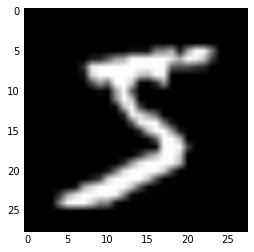

In [4]:
plt.imshow(X_train[0,0], cmap='gray')

In [5]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
            
        ts = targets[excerpt]
        ohe_labels = OneHotEncoder(10, sparse=False).fit_transform(ts[:,None])
        yield inputs[excerpt], targets[excerpt]#ohe_labels

In [6]:
#batch generator classic
def batch_gen_classic(batch_size, X, y):
    num_samps  = len(X)
    assert num_samps == len(y)
    
    inds = np.random.randint(low=0, high=num_samps-1, size=batch_size)
    
    inputs = X[inds]
    labels = y[inds]
    ohe_labels = OneHotEncoder(10, sparse=False).fit_transform(labels[:,None])

    return inputs, ohe_labels
    
#batch generator pairwise perfect
def batch_gen_pc(batch_size, X, y):
    num_samps  = len(X)
    assert num_samps == len(y)
    
    inds = np.random.randint(low=0, high=num_samps-1, size=batch_size)
    
    inputs = X[inds]
    labels = y[inds]
    
    #turn the labels into pc results
    pc_labels = labels[0::2] < labels[1::2] #where 1st of pair is bigger than 2nd
    
    return inputs, pc_labels.astype(int)

#batch generator pairwise btl
def batch_gen_pcbtl(batch_size, X, y):
    num_samps  = len(X)
    assert num_samps == len(y)
    
    inds = np.random.randint(low=0, high=num_samps-1, size=batch_size)
    
    inputs = X[inds]
    labels = y[inds]
    
    #get the probs pof first column victory
    pc_tot = labels[0::2] + labels[1::2] #where 1st of pair is bigger than 2nd
    pc_vic_prob = labels[0::2].astype(float)/pc_tot.astype(float)
    
    #see if first column wins (i.e. is random number less than p?)
    random_vec = np.random.rand(pc_vic_prob.shape[0])
    
    pc_1vic = random_vec > pc_vic_prob

    return inputs, pc_1vic.astype(int)

In [305]:
#NEW LAYER CLASSES
#repeat batches for monte carlo sampling
class RepeatLayer(lasagne.layers.Layer):
    #tiles tensor in a given dimension
    def __init__(self, incoming, reps, axis=0, **kwargs):
        super(RepeatLayer, self).__init__(incoming, **kwargs)
        self.reps = reps
        self.axis = axis
        
    def get_output_shape_for(self, input_shape):
        return tuple([None] + list(input_shape[1:]))

    def get_output_for(self, input, **kwargs):
        return T.extra_ops.repeat(input, self.reps, axis=self.axis)
    
#obtain mean and var estimates from dropout samples
class MCMomentsLayer(lasagne.layers.Layer):
    #computes mean and variance from samples
    def __init__(self, incoming, samples, **kwargs):
        super(MCMomentsLayer, self).__init__(incoming, **kwargs)
        self.samples = samples

    def get_output_shape_for(self, input_shape):
        #returns (mean, var)
        return (None, 2)

    def get_output_for(self, input, **kwargs):
        #reshape input (1dim) so that congruent samples are rows
        reshaped = T.reshape(input, (-1, self.samples))
        samp_mu = T.mean(reshaped, axis=1)
        samp_sigma = T.pow(T.var(reshaped, axis=1), 0.5)
        return T.concatenate([samp_mu[:, None], samp_sigma[:, None]], axis=1) #samp_mean[:, None]#

###--- explicit btl model
class BTLLayer(lasagne.layers.Layer):
    #takes a two column input - each column contains the value on some scale
    def get_output_for(self, input, **kwargs):
        #calculate the probs of pairwise comparison win
        total_col = input[:,0] + input[:,1]
        total_mat = T.extra_ops.repeat(x=total_col[:,None], repeats=2, axis=1)
        return input/total_mat

###--- explicit trueskill model
#NB TS uncertainty might not make sense on MNIST since number is not a continuous visual property and the
#GT comparisons here are generated on the true labels (rather than on some uncertainty in visual appearance) 
class TSLayer(lasagne.layers.Layer):
    #takes a four column input - (mu1, sigma1, mu2, sigma2)
    def __init__(self, incoming, beta, **kwargs):
        super(TSLayer, self).__init__(incoming, **kwargs)
        self.beta = beta
    
    def get_output_for(self, input, **kwargs):
        #calculate the probs of pairwise comparison win       
        #fraction calc for _normcdf
        delta_mu = input[:,0] - input[:,2]
        denom_s = (T.pow(input[:,1], 2) + T.pow(input[:,3], 2)) + (2 * T.pow(self.beta, 2))
        denom = T.sqrt(denom_s)
        normcdf_arg = delta_mu/denom
        
        #calc the probs
        p1 = 0.5 * T.erfc(-(normcdf_arg) / T.sqrt(2)) #normcdf calc
        p2 = 0.5 * T.erfc(-(-normcdf_arg) / T.sqrt(2))
        
        return T.concatenate([p1[:,None], p2[:,None]], axis=1)
    
    def get_output_shape_for(self, input_shape):
        batch_size = input_shape[0]
        pred = input_shape[1]/2 #i.e. (mu1, sig1, mu2, sig2) => (P(1>2), P(2>1))        
        return (batch_size, pred)

In [312]:
#net builders
def mlp_feat_extract(X):
    net = OrderedDict()

    net['input'] = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=X)

    net['dense1'] = lasagne.layers.DenseLayer(net['input'], 1000, \
                                                   nonlinearity=lasagne.nonlinearities.rectify)

    net['dense2'] = lasagne.layers.DenseLayer(net['dense1'], 1000, \
                                                   nonlinearity=lasagne.nonlinearities.rectify)

    net['dense3'] = lasagne.layers.DenseLayer(net['dense2'], 100, \
                                                   nonlinearity=lasagne.nonlinearities.rectify)
    
    net['softmax'] = lasagne.layers.DenseLayer(net['dense3'], 10, \
                                                   nonlinearity=lasagne.nonlinearities.softmax)
    return net

def cnn_feat_extract(X):
    net = OrderedDict()

    net['input'] = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=X)

    
    
    ###----
    net['conv1'] = lasagne.layers.Conv2DLayer(net['input'], num_filters=32, filter_size=(5,5), \
                                               nonlinearity=lasagne.nonlinearities.rectify)
    net['pool1'] = lasagne.layers.MaxPool2DLayer(net['conv1'], pool_size=(2, 2))
    ###----
    
    
    ###-----
    net['conv2'] = lasagne.layers.Conv2DLayer(net['pool1'], num_filters=32, filter_size=(3,3), \
                                              nonlinearity=lasagne.nonlinearities.rectify)
    net['conv3'] = lasagne.layers.Conv2DLayer(net['conv2'], num_filters=16, filter_size=(3,3), \
                                              nonlinearity=lasagne.nonlinearities.rectify)
    net['conv4'] = lasagne.layers.Conv2DLayer(net['conv3'], num_filters=16, filter_size=(3,3), \
                                              nonlinearity=lasagne.nonlinearities.rectify)
    net['pool2'] = lasagne.layers.MaxPool2DLayer(net['conv4'], pool_size=(2, 2))
    ###---
    
    
    net['fc1'] = lasagne.layers.DenseLayer(net['pool2'], num_units=256, \
                                           nonlinearity=lasagne.nonlinearities.rectify)
    
    net['fc2'] = lasagne.layers.DenseLayer(net['fc1'], num_units=128, \
                                           nonlinearity=lasagne.nonlinearities.rectify)

    return net


def mc_regression(X, p=0.5, samples=40):
    #build mlp with dropout, and monte carlo sampling
    net = OrderedDict()

    net['input'] = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=X)
    net['repeat'] = RepeatLayer(net['input'], samples)
    
    #----
    net['dense1'] = lasagne.layers.DenseLayer(net['repeat'], 1000, \
                                                   nonlinearity=lasagne.nonlinearities.rectify)
    net['drop1'] = lasagne.layers.DropoutLayer(net['dense1'], p=p)

    #----
    net['dense2'] = lasagne.layers.DenseLayer(net['drop1'], 1000, \
                                                   nonlinearity=lasagne.nonlinearities.rectify)
    net['drop2'] = lasagne.layers.DropoutLayer(net['dense2'], p=p)
    
    #----
    net['dense3'] = lasagne.layers.DenseLayer(net['drop2'], 100, \
                                                   nonlinearity=lasagne.nonlinearities.rectify)
    net['drop3'] = lasagne.layers.DropoutLayer(net['dense3'], p=p)
    
    #----
    net['softmax'] = lasagne.layers.DenseLayer(net['drop3'], 1, \
                                                   nonlinearity=lasagne.nonlinearities.linear)
    
    #----
    net['bayes'] = MCMomentsLayer(net['softmax'], samples=samples)
    
    return net

def mc_cnn(X, p=0.5, samples=40):
    #build mlp with dropout, and monte carlo sampling
    net = OrderedDict()

    net['input'] = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=X)
    net['repeat'] = RepeatLayer(net['input'], samples)
    
    ###----
    net['conv1'] = lasagne.layers.Conv2DLayer(net['repeat'], num_filters=32, filter_size=(5,5), \
                                               nonlinearity=lasagne.nonlinearities.rectify)
    net['conv1_d'] = lasagne.layers.DropoutLayer(net['conv1'], p=p)
    net['pool1'] = lasagne.layers.MaxPool2DLayer(net['conv1_d'], (2,2))
    ###----
    
    
    ###-----
    net['conv2'] = lasagne.layers.Conv2DLayer(net['pool1'], num_filters=32, filter_size=(3,3), \
                                              nonlinearity=lasagne.nonlinearities.rectify)
    net['conv3'] = lasagne.layers.Conv2DLayer(net['conv2'], num_filters=16, filter_size=(3,3), \
                                              nonlinearity=lasagne.nonlinearities.rectify)
    net['conv4'] = lasagne.layers.Conv2DLayer(net['conv3'], num_filters=16, filter_size=(3,3), \
                                              nonlinearity=lasagne.nonlinearities.rectify)
    net['conv4_d'] = lasagne.layers.DropoutLayer(net['conv4'], p=p)
    net['pool4'] = lasagne.layers.MaxPool2DLayer(net['conv4_d'], (2,2))
    ###---
    
    ###--- FULLY CONNECTED
    net['fc1'] = lasagne.layers.DenseLayer(net['pool4'], num_units=512, \
                                           nonlinearity=lasagne.nonlinearities.rectify)
    net['fc1_d'] = lasagne.layers.DropoutLayer(net['fc1'], p=p)
    
    
    net['fc2'] = lasagne.layers.DenseLayer(net['fc1_d'], num_units=256, \
                                           nonlinearity=lasagne.nonlinearities.rectify)
    net['fc2_d'] = lasagne.layers.DropoutLayer(net['fc2'], p=p)
    
    #----
    net['reg_out'] = lasagne.layers.DenseLayer(net['fc2_d'], 1, \
                                                   nonlinearity=lasagne.nonlinearities.linear)
    
    #----
    net['bayes'] = MCMomentsLayer(net['reg_out'], samples=samples)
    
    return net

In [313]:
#net toppers
def add_siamese(net):
    #concatenate representations (halving the batch (i.e. zeroth) dimension)
    layer_list = [net[layer] for layer in net]
    current_shape = lasagne.layers.get_output_shape(layer_list[-1])
    
    new_shape = list(current_shape)
    new_shape[0] = -1 #free the batch dimension
    new_shape[1] = new_shape[1]*2 # double the 1st
    new_shape = tuple(new_shape)

    net['fusion'] = lasagne.layers.ReshapeLayer(layer_list[-1], new_shape)
    
    return net

def add_softmax(net, num_units=10):
    #concatenate representations (halving the batch (i.e. zeroth) dimension)
    layer_list = [net[layer] for layer in net]
    
    #add softmax
    net['softmax'] = lasagne.layers.DenseLayer(layer_list[-1], num_units=num_units, \
                                               nonlinearity=lasagne.nonlinearities.softmax)
    
    return net

def add_ts_naive(net):
    layer_list = [net[layer] for layer in net]
    
    #dense connect to 2 outs -> (mu, sigma)
    net['reg'] = lasagne.layers.DenseLayer(layer_list[-1], num_units=2, \
                                           nonlinearity=lasagne.nonlinearities.linear,
                                           W = lasagne.init.Constant(1))
    
    #combine across 0th dimension 
    net['fusion'] = lasagne.layers.ReshapeLayer(net['reg'], (-1, 4)) #now has 4 columns (mu1, sigma1, mu2, sigma2)
    
    #calc the ts probs
    net['out'] = TSLayer(net['fusion'])
    return net

def add_ts(net, beta=0.5):
    #puts truskill comparison layer on MCMomentEstimate layer
    #input is a N*2 X 2 matrix, where N is number of matches
    layer_list = [net[layer] for layer in net]
    
    #combine across 0th dimension 
    net['fusion'] = lasagne.layers.ReshapeLayer(layer_list[-1], (-1, 4)) #now has 4 columns (mu1, sigma1, mu2, sigma2)

    #calc the ts probs
    net['out'] = TSLayer(net['fusion'], beta=beta)
    return net

def add_btl(net):
    layer_list = [net[layer] for layer in net]
    net['reg'] = lasagne.layers.DenseLayer(layer_list[-1], num_units=1, \
                                               nonlinearity=lasagne.nonlinearities.sigmoid)
    
    #combine across 0th dimension 
    net['fusion'] = lasagne.layers.ReshapeLayer(net['reg'], (-1, 2)) #now has 2 columns
    
    #calc the btl probs
    net['out'] = BTLLayer(net['fusion'])
    return net

In [314]:
#CREATE NET + TRAIN FNs
#initialise inputs and outputs
X = T.tensor4('X')
y = T.ivector('y') # <- need to specify the dim of the inputs and outputs

#build and calc the net output
#net = mlp_feat_extract(X)
#net = cnn_feat_extract(X)
net = mc_cnn(X)
net = add_ts(net, beta=4.166)
#net = add_btl(net)
#net = add_siamese(net)
#net = add_softmax(net, num_units=2)

layer_list = [net[layer] for layer in net]
full_output = lasagne.layers.get_output(layer_list)
y_pred = full_output[-1]

#calc the loss
loss = lasagne.objectives.categorical_crossentropy(y_pred, y)
#loss = lasagne.objectives.binary_crossentropy(y_pred, y)
loss = loss.mean() #mean over the batch
acc = lasagne.objectives.categorical_accuracy(y_pred, y)
#acc = lasagne.objectives.binary_accuracy(y_pred, y)
acc = acc.mean()

#get params and backprop loss across
params = lasagne.layers.get_all_params(layer_list[-1], trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=.1, momentum=0.9)
#updates = lasagne.updates.sgd(loss, params, learning_rate=.00001)

#compile the functions
from theano.compile.nanguardmode import NanGuardMode

check_fn = theano.function(inputs = [X], outputs=full_output, allow_input_downcast=True)
train_fn = theano.function(inputs = [X, y], outputs=loss, updates=updates, allow_input_downcast=True)
pass_fn = theano.function(inputs=[X, y], outputs=[loss, acc, y_pred], allow_input_downcast=True) # <- for passing test data

### Train (siamese)

In [315]:
t0 = time.time()
num_epochs = 20
batches_per_epoch = 100
epoch_loss_hist = []
for ep in xrange(num_epochs):
    train_batches = 0
    train_loss = 0
    for _ in xrange(batches_per_epoch):
        Xb, yb = batch_gen_pc(500, X_train, y_train)
        train_loss += train_fn(Xb, yb) # <- trains the network
        train_batches += 1

    #forward pass over validation data for reporting
    val_loss = 0
    val_batches = 0
    val_acc = 0
    for _ in xrange(3):
        Xb, yb = batch_gen_pc(500, X_train, y_train)
        vl, va, y_pred = pass_fn(Xb, yb) # <- trains the network
        val_loss += vl
        val_batches += 1
        val_acc += va
        
    #report the results after each epoch
    clear_output()
    epoch_loss_hist.append({'train': train_loss/float(train_batches), 'val': val_loss/float(val_batches)})
    print 'epoch {0} results: train loss of {1}, val acc of {2}, taken {3}'.format(ep, 
                                                                         train_loss/float(train_batches),
                                                                         val_acc/float(val_batches),
                                                                                  time.time()-t0)
                                                                         #val_loss/float(val_batches))

epoch 17 results: train loss of 0.113514299169, val acc of 0.942666666667, taken 832.673367023


KeyboardInterrupt: 

## visualise results

In [316]:
X_examples, labs = batch_gen_pcbtl(100, X_val, y_val)
full_output = check_fn(X_examples)

[ 0.57701403  0.42298597]
[24.047667, 2.7475004974725774, 17.221691, 5.8144938012937297]


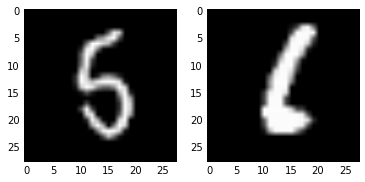

In [318]:
comp = 3
indl = comp*2
indr = 1+(comp*2)
f, ax = plt.subplots(1, 2)
ax[0].imshow(full_output[0][indl,0], cmap='gray')
ax[1].imshow(full_output[0][indr,0], cmap='gray')
p1_win = full_output[-1][comp]
ratings = full_output[-2][comp]
print p1_win
print [ratings[0], ratings[1]**.5, ratings[2], ratings[3]**.5]

In [277]:
#check win prob
delta_mu = ratings[0] - ratings[2]
denom_s = (ratings[1] + ratings[3]) + (2 * .05**2)
denom = np.sqrt(denom_s)

#calc the prob of player 1 winning
p1 = norm.cdf(delta_mu/float(denom))
print p1, delta_mu

0.000618279663259 -3.34585


### full validation set check

In [322]:
#calc the whole lot (may take a while w dropout)
out = check_fn(X_val[:800])

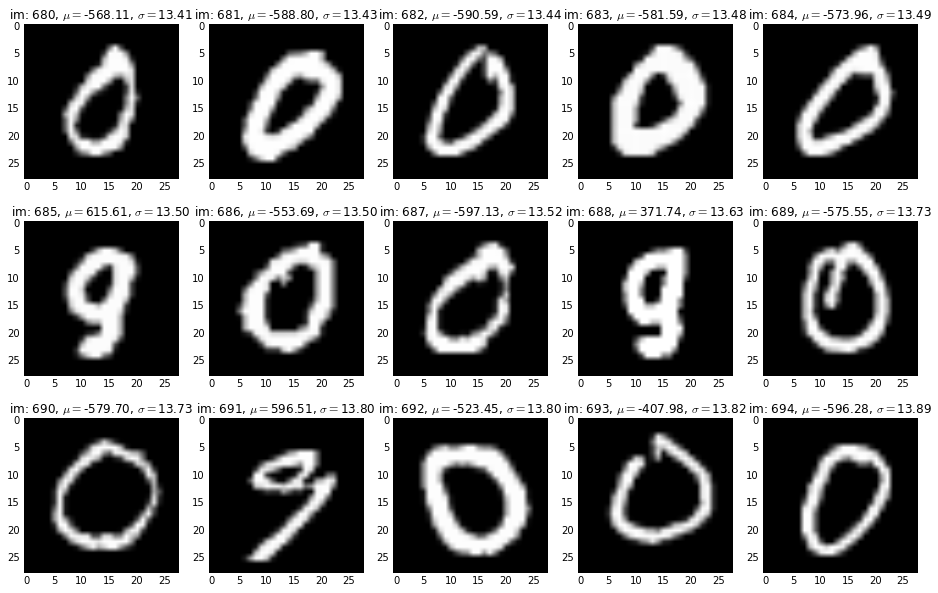

In [340]:
#visualise some results
inds = np.argsort(out[-3][:,1])
rows = 3
cols = 5
f, ax = plt.subplots(rows,cols, figsize=(16, 10))
start_im=680
for irow in xrange(rows):
    for icol in xrange(cols):
        ax[irow, icol].imshow(out[0][inds[start_im],0], cmap='gray')
        title_string = 'im: {2}, $\mu = ${0:.2f}, $\sigma = ${1:.2f}'.\
            format(out[-3][inds[start_im], 0], pow(out[-3][inds[start_im], 1],0.5), start_im)
        ax[irow, icol].set_title(title_string)
        start_im += 1

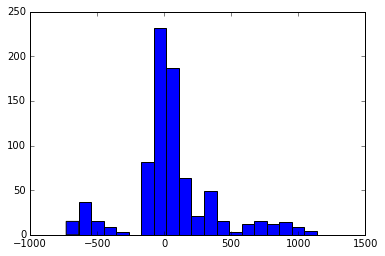

In [331]:
_ =plt.hist(out[-3][:,0], bins=20)

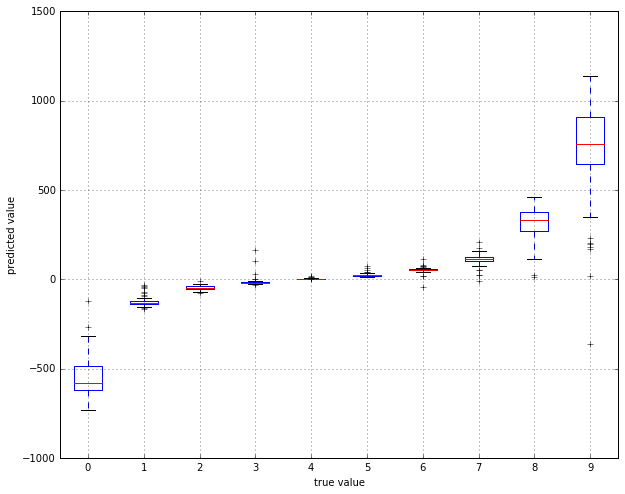

In [333]:
#make box plot
data_list = []
for v in xrange(10):
    #select values of v
    inds = y_val[:800] == v
    preds = out[-3][inds,0]
    data_list.append(preds)

f, ax = plt.subplots(figsize=(10,8))
_ = plt.boxplot(data_list)
_ = ax.set_xticklabels(range(10))
_ = ax.set_ylabel('predicted value')
_ = ax.set_xlabel('true value')
#_ = ax.plot([1,10], [0,9], color='k')
plt.grid()

In [ ]:
#URGENT TODO

#generate gt trueskill vals
#generate comparison results using the values as ratings

#### TODO
- create function which takes in an image and spits out the regression value
        - can just use output from check_fn (full_output[-2]) iterate across examples in the val set, collecting stats, plot scatter plot of labels vs the regressed values

- look at uncertainty in BTL value
- compare with actual btl generated data


For publication:

experiments: 
- compare with softmax network followed by BTL estimation
- compare with fixed representation (i.e. not allowing backprop past final layer)